<img src="https://scai.sorbonne-universite.fr/files_app/e/1161/35259fe5ddd82aedfda8040d0206bf4b.png" width=700/>

# TP 1.2 : Reconnaissance d’images par apprentissage profond

### Lundi 25 aout 2025

🙏 Remerciements & crédits
Ce notebook reprend le code original de l'équipe **PREDIS** de l'Université Laval

Tess Berthier, Antoine Dufour et Gabriel Leclerc


## La classification d’images... c'est quoi?

La **classification d’images** consiste à attribuer une **étiquette (classe)** à une image donnée en fonction de son contenu visuel.  

Exemple : reconnaître si une image contient un **chat** ou un **chien**

Cette tâche est généralement réalisée à l’aide de **réseaux de neurones convolutionnels (CNN)** ou de modèles modernes comme les **transformers visuels (ViT)**.

### Exemples d’utilisation de la classification d’images en agroalimentaire et agriculture

- 🍽️ **Suivi nutritionnel**  
  - Utilisé pour la **surveillance nutritionnelle**, l’**estimation des calories** et le **suivi diététique personnalisé**.  
  - Exemple : classification des aliments → extraction d’informations nutritionnelles.  

- 🏭 **Contrôle qualité en production**  
  - Détection des produits **défectueux, avariés ou contaminés** sur les lignes de production.  
  - Classification : **Bon produit** vs **produit défectueux**.  

- 🍎 **Évaluation de la maturité et de la qualité des produits**  
  - Classification des **fruits, légumes ou grains** selon leur **maturité, couleur ou présence de défauts**.  
  - Classification : **Mûr** vs **non mûr**.  

- 🌿 **Détection des maladies des plantes**  
  - Identification des maladies à partir d’images de feuilles ou de cultures.  
  - Classification : **Plante saine** vs **plante malade**.  

- 🌱 **Détection des mauvaises herbes**  
  - Identification des mauvaises herbes dans les champs pour permettre une gestion ciblée.  
  - Classification : **Culture** vs **mauvaise herbe** → agriculture de précision.  

- 🐖 **Suivi de la santé des animaux d'élevage**  
  - Détection automatique de la toux ou d’une perte de mobilité via des caméras dans les bâtiments d’élevage.  
  - Classification : **animal sain** vs **animal malade**.  

# L'objectif du TP d'aujourd'hui
Nous allons entrainer un modèle d'apprentissage profond pour **classifier** les images du jeu de données **Food-101** pour identifier un plat à partir d'une image.

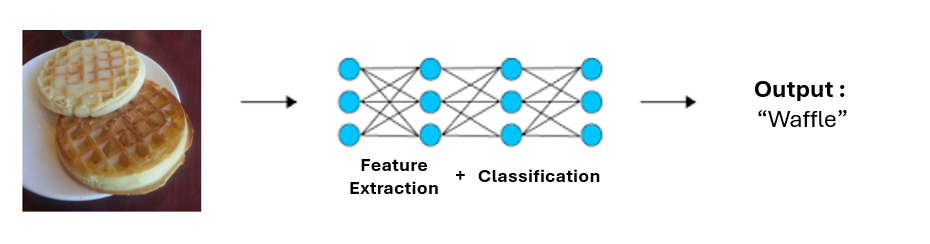

Ce genre d’identification nous permettrait, par exemple:
- de développer un produit réalisant l’analyse nutritionnelle d’un plat à partir d’une photo,
- ou encore de proposer des suggestions pour améliorer la qualité de l’alimentation des utilisateurs.  


### Jeu de données Food-101

**Food-101** est un jeu de données largement utilisé pour la classification d’images dans le domaine de l’alimentation.  
Il est intégré à PyTorch via la librairie **`torchvision.datasets`** et peut être téléchargé facilement.  

#### Caractéristiques principales
- 🍽️ **Nombre de classes** : 101 catégories de plats (ex. *pizza*, *ramen*, *apple pie*, etc.).  
- 🖼️ **Nombre total d’images** : 101 000 (soit 1 000 images par classe).  
- 📐 **Taille des images** : environ 512 × 512 pixels en JPEG.  


# Connection à un GPU
Nous allons maintenant définir notre **device** : il s’agira d’un **GPU** s’il est disponible, afin d’accélérer les calculs de ces différentes couches.

Le TP se fait avec un **CPU** (option de base), mais les **GPU** (*Graphics Processing Units*) sont des processeurs optimisés pour le traitement parallèle de données, en particulier les images, et devraient accélérer l’entraînement.  


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List the available GPUs
gpu_list = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(gpu_list)
device

# Initialisation du Notebook

Nous commençons comme plus tôt par importer les librairies que nous allons utiliser, mais aussi les liens vers certains dossiers qui contiennent des algorithmes pertinents (comme les modèles ou encore la manière d'entraîner ceux-ci)

In [ ]:
def is_in_colab():
    try:
        import google.colab
        return True
    except:
        return False

print(f"Running in Colab: {is_in_colab()}")

if is_in_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/intro_deep_learning_food101-main

In [ ]:
# Install librairies not already in Colab
!pip install -q lightning-utilities torchmetrics --no-deps

import os
import sys

import torch
import torchvision
import random

import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import tabulate
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1

from torch.utils.data import Subset, DataLoader
from torchmetrics.classification import MulticlassAccuracy
from tqdm.notebook import tqdm
from dataloaders.dataloaders import Food101Dataset
from utils.training import train_and_validate

# Gestion des grands jeux de données

Lorsqu’on travaille avec des jeux de données volumineux (ex. des images),  
il devient vite très difficile, voire impossible, de conserver toutes les images en mémoire pendant que l’on effectue des manipulations dessus  
(*séparation train-test, transformations, entraînement de modèles*), sans surcharger la mémoire (RAM) de notre ordinateur.  

---

#### Exemple : Food-101
- Taille du dataset : **≈ 14 GB** après décompression  
- Mémoire disponible sur Colab : **≈ 12,7 GB de RAM**  

➡️ Impossible de tout charger directement en mémoire.  

---

#### La solution : l'outil `Dataset` de PyTorch
Pour résoudre ce problème, nous avons écrit une fonction `Food101Dataset`.  
Cette fonction transforme notre dataset en objet
[`torch.utils.data.Dataset`](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html).  

En pratique :  
- L’objet `Dataset` prend toutes les adresses des images du dataset (qu'on lui aura indiqué via un fichier `.json`)  
- Mais sans jamais charger les images directement en mémoire.  
- Seule l’**adresse du fichier** (ex. `data/food-101/images/apple_pie/21063.jpg`) est stockée  
- Cela permet de préparer les manipulations (*train-test split, transformations, contrôle qualité, etntrainement, etc.*)  
  sans garder toutes les images en mémoire.  

---

#### Rôle du DataLoader
Lors de l’entraînement, nous envoyons nos datasets dans un [**Dataloader**](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) qui va :  
1. **Charger les images du dataset par lots** (*batches*) de 32 ou 64  
2. **Appliquer les transformations** que nous aurons définies plus bas  
3. **Envoyer les images transformées** au modèle pour l’apprentissage  

In [ ]:
# Create datasets
transformations = None # Tell the dataloader to not make any transformations to the images for now

train_ds = Food101Dataset(json_path='./data/food-101/meta2/train.json', root_dir='./data/food-101/images', transform=transformations)
valid_ds = Food101Dataset(json_path='./data/food-101/meta2/validation.json', root_dir='./data/food-101/images', transform=transformations)
test_ds = Food101Dataset(json_path='./data/food-101/meta2/test.json', root_dir='./data/food-101/images', transform=transformations)
classes = train_ds.classes
class_to_idx = train_ds.class_to_idx

Cela nous donne non seulement nos trois jeux de données, mais aussi le nom des classes d'aliments que nous avons ainsi que leurs indices.

Étudions un peu notre jeu :

In [ ]:
num_categories = len(classes)

statistics = [
    ["Splits", "train", "valid", "test"],
    ["Size", len(train_ds), len(valid_ds), len(test_ds)],
    ["Categories", num_categories, num_categories, num_categories],
    ["Average", int(len(train_ds)/num_categories), int(len(valid_ds)/num_categories), int(len(test_ds)/num_categories)]
]
table = tabulate.tabulate(statistics, tablefmt='html')
display(HTML(table))

On peut ainsi voir que notre jeu de données a été bien réparti : nous avons 80% de celui-ci comme jeu d'entraînement et 10% respectivement pour la validation et le test.

Nous pouvons maintenant choisir de visualiser des images dans nos jeux de données. Choisissons par exemple de regarder l'image numéro 0 dans notre jeu d'entraînement ainsi que sa classe en titre :

In [ ]:
image_id = 0 # We can reference individual images with an number ID (e.g. 0)

img, label = train_ds[image_id]
fig = plt.figure()
ax = fig.subplots()
ax.imshow(img)
ax.set_title(f"{classes[label]}")
ax.set_axis_off()

**Question:** Dans la prochaine cellule, veuillez afficher l'image numéro **1000** du **jeu de test** en suivant la cellule précédente qui a affiché notre tarte au pomme.

In [ ]:
# Écrivez votre code ici:





In [ ]:
#@title Réponse
image_id = 1000
img, label = test_ds[image_id]
fig = plt.figure()
ax = fig.subplots()
ax.imshow(img)
ax.set_title(f"{classes[label]}")
ax.set_axis_off()

Exécutez maintenant la cellule suivante afin de visualiser des images prises au hasard dans notre jeu d'entraînement (vous pouvez aussi choisir de regarder le test ou la validation, au choix !)

In [ ]:
random_indexes = random.sample(range(0, len(train_ds)), 9) # Take 9 random images indexes

fig = plt.figure(figsize=(8, 8))
grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.3,
                 )

for ax, idx in zip(grid, random_indexes):
    # Iterating over the grid returns the Axes.
    img, label = train_ds[idx]
    ax.text(0, 0, classes[label], va="top", backgroundcolor="white")
    ax.imshow(train_ds[idx][0])
    ax.set_axis_off()

Vous pouvez relancer cette cellule plusieurs fois, grâce à la composante "random" elle vous donnera des images aléatoires à chaque fois. Cela peut être une bonne idée pour avoir un apperçu de l'état de la donnée assez rapidement.

# Transformations des données

Commençons tout d’abord par recréer notre jeu de test.  
Cette fois-ci, nous allons lui appliquer les **transformations suivantes** :  

- 📏 **Réduction de la taille des images** : pour accélérer les calculs. Sinon, nous n’aurons pas suffisamment de temps pour terminer le TP!  
- 🖼️ **Recadrage centré** : afin d’obtenir des images non distordues lors de leur mise à la bonne taille (carrée plutôt que rectangulaire).  
  Le recadrage est toujours effectué au centre, ce qui évite de transformer différemment les images à chaque passage.  
- 🔄 **Conversion en tenseur** : le réseau de neurones ne peut pas lire d’images directement. Cette étape est donc indispensable.  
- 🎚️ **Normalisation** : permet d’harmoniser l’intensité globale des images.  
  Cela est particulièrement utile lors de l’entraînement, car les images peuvent provenir de sources variées (téléphone Android, appareil photo, iPhone, etc.).  
  La normalisation est calculée à partir de la **moyenne** et de la **variance générale** du jeu de données.  


In [ ]:
img_size = 64 # Define the image size to 64x64 pixels
n_classes = 101

train_transforms = transforms.Compose([transforms.Resize(img_size), # Resize so the smaller edge of the image will be matched to this number.
                                       transforms.RandomCrop(img_size), # Make sur the image is squared N x N so crop a img_size square
                                       transforms.ToTensor(), # To pytorch tensor
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # normalize (x-mean)/std

test_transforms = transforms.Compose([transforms.Resize(img_size), # resize image
                                       transforms.RandomCrop(img_size), # Make sur the image is squared N x N so crop a img_size square
                                       transforms.ToTensor(), # transform into a tensor (the format normally used as input neural net)
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # Normalize image color intensity


Nous venons de créer la transformation pour le **jeu d’apprentissage**  


- Nous allons utiliser les jeux d’entraînement **et de validation** pour créer le **meilleur modèle possible**.  
- Le **jeu de validation** va jouer le rôle de données *jamais vues* (*out-of-sample*),  
  afin de vérifier comment le réseau se comporte après entraînement.  

---

**Question:** Dans la cellule suivante, créez `valid_transforms`,  
qui doit être **identique** à `train_transforms` défini plus tôt.  

In [ ]:
# Écrivez votre code ici:






In [ ]:
#@title Réponse
valid_transforms = transforms.Compose([transforms.Resize(img_size),
                                       transforms.CenterCrop(img_size), # Center crop as we do not want randomness in test
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

Super! On peut maintenant créer nos datasets `train_ds`, `valid_ds` et `test_ds`de la même manière qu'avant, en choisissant les bonnes transformations ;)

In [ ]:
train_ds = Food101Dataset(json_path='./data/food-101/meta2/train.json', root_dir='./data/food-101/images', transform=train_transforms)
valid_ds = Food101Dataset(json_path='./data/food-101/meta2/validation.json', root_dir='./data/food-101/images', transform=valid_transforms)
test_ds = Food101Dataset(json_path='./data/food-101/meta2/test.json', root_dir='./data/food-101/images', transform=test_transforms)

# Sous-échantillons du jeu de données

**L'évaluation** d'un réseau de neurones sur le dataset de 101 000 images serait **très coûteux en temps** (environ 42h).  

Pour ne pas finir le TP trop tard, nous allons **sous-échantillonner** notre jeu de données.  

Concrètement, nous allons créer des jeux de données contenant :  
- seulement **10 classes**,  
- et **4 images par classe**.  

(👀 Oui, c’est peu, mais l’objectif est avant tout d’aller vite !)  

ici nous roulons un petit morceau de code afin de créer `subset_train_ds`et `subset_valid_ds`qui sont en fait des sous échantillons de nos jeux de données créés avec 10 classes et 4 images par classe.

In [ ]:
# Don't worry too much about the code bellow
n_classes = 10  # Number of class to keep
n_samples_per_class = 4  # Number of images to keep
labels = np.array(train_ds.labels)

# Train subset
subsets_per_class = []
for class_idx in range(n_classes):
    class_indices = np.where(labels==class_idx)[0][:n_samples_per_class]
    subsets_per_class.extend(class_indices)

labels_valid = np.array(valid_ds.labels)

# Valid subset
subsets_per_class_valid = []
for class_idx in range(n_classes):
    class_indices_valid = np.where(labels_valid==class_idx)[0][:n_samples_per_class]
    subsets_per_class_valid.extend(class_indices_valid)

# Test subset
labels_test = np.array(test_ds.labels)

subsets_per_class_test = []
for class_idx in range(n_classes):
    class_indices_test = np.where(labels_test==class_idx)[0][:n_samples_per_class]
    subsets_per_class_test.extend(class_indices_test)

# Create a Subset from the original dataset
subset_train_ds = Subset(train_ds, subsets_per_class)
subset_valid_ds = Subset(valid_ds, subsets_per_class_valid)
subset_test_ds = Subset(test_ds, subsets_per_class_test)


On peut alors créer nos dataloaders, voici un exemple pour celui de train


In [ ]:
batch_size = 4
num_workers = 2
trainloader = torch.utils.data.DataLoader(subset_train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

testloader = torch.utils.data.DataLoader(subset_test_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

**Question:** Veuillez créer `validloader` avec le dataset sous-échantillonés `subset_valid_ds `

In [ ]:
# Écrivez votre code ici





In [ ]:
#@title Réponse :
validloader = torch.utils.data.DataLoader(subset_valid_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Entrainement d'un modèle de classification d'images

## Les réseaux de neurons convolutionels (CNN)

Un **réseau de neurones convolutionnel (CNN)** est un modèle d’intelligence artificielle conçu pour analyser des images en apprenant automatiquement des **caractéristiques visuelles** (bords, formes, textures).

Il combine des couches de neurones de **convolutions** et de **pooling** pour extraire progressivement des informations, puis des couches de neurones **Linéaire** pour classer l’image dans une catégorie.


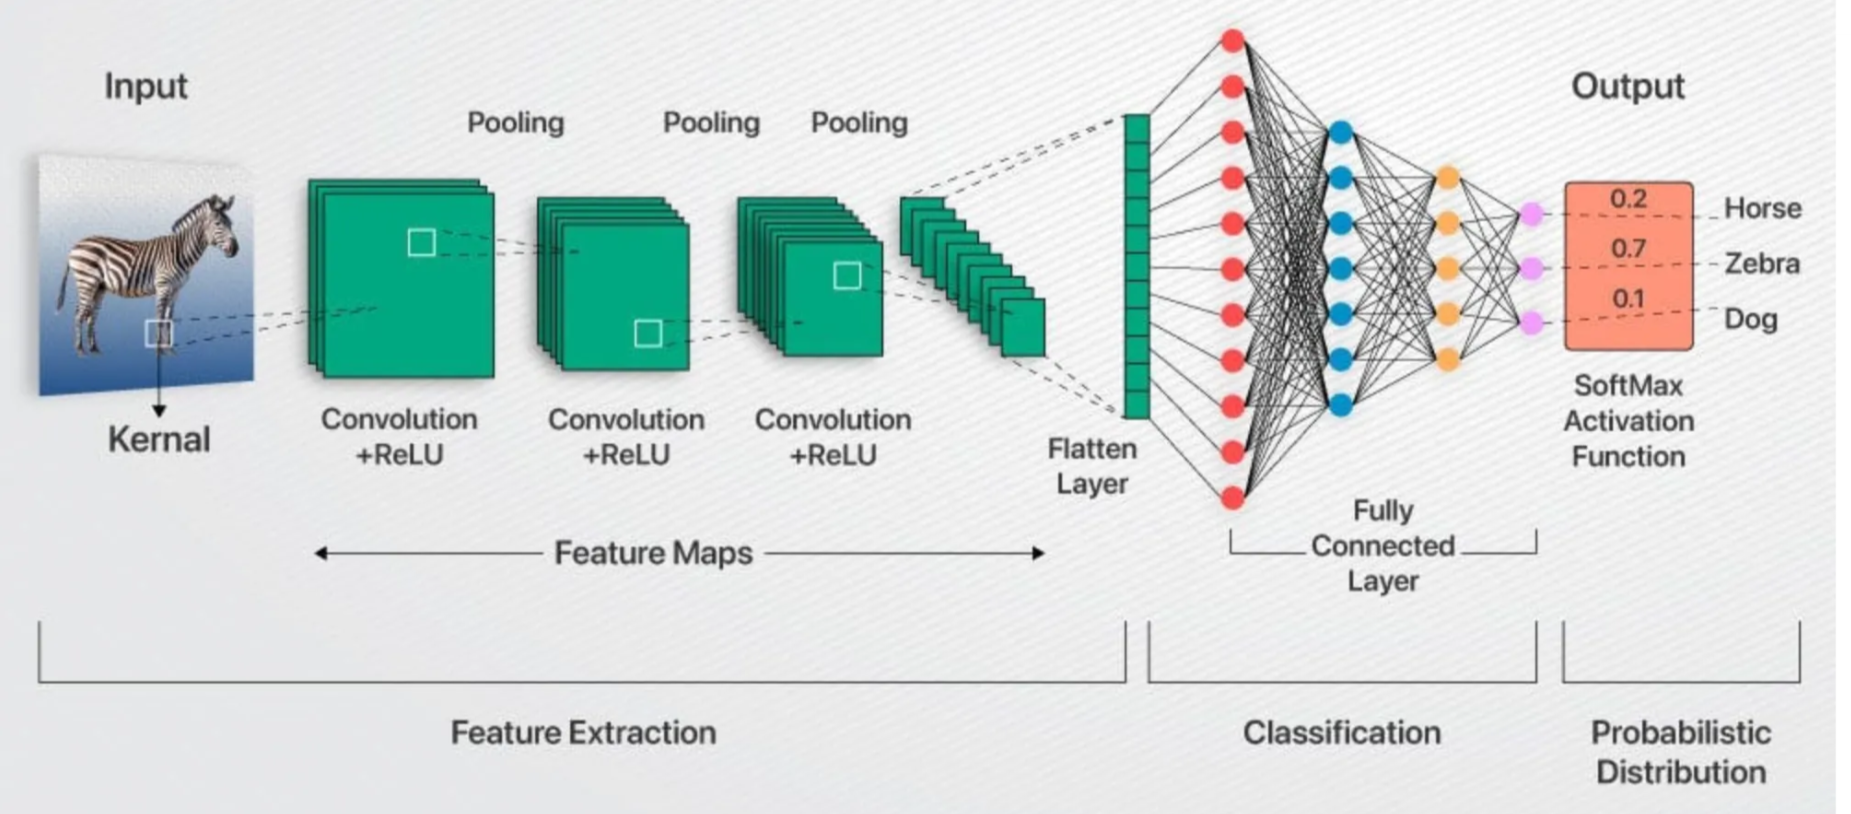

### Nous pouvons maintenant définir la structure de notre modèle !  

Pour vous faciliter la tâche, nous avons créé un modèle très basique appelé **Network1**.  

D'autres modèles ont également été enregistrés dans le dossier `networks`.  
Il suffit de les importer via :  

```python
from networks.networks import Network1
```
Puis de les instancier dans l’objet model :
```python
model = Network1(n_classes=n_classes, img_size=img_size)
```



In [ ]:
# A look at what the code looks like when you import it via :  from networks.networks import Network1
class Network1(nn.Module):
    def __init__(self, n_classes: int, img_size: int):
        super().__init__()
        self.convs = nn.Sequential(*[nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2), # Convolutional layer (neural net to analyze images)
                                     nn.ReLU(), # ReLu: Activation function of the convolutional layer above (how each neurons in the neural net will respond based on its input)
                                     nn.MaxPool2d(2, 2), # Max pooling: A layer that combines all the output from the convolutional layer above to pass it to the next neuron layer
                                     nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2),  # Convolutional layer (neural net to analyze images)
                                     nn.ReLU(), # ReLU: Activation function of the convolutional layer above (how each neurons in the neural net will respond based on its input)
                                     nn.MaxPool2d(2, 2)])  # Max pooling: A layer that combines all the output from the convolutional layer above to pass it to the next neuron layer

        self.fcs = nn.Sequential(*[nn.Linear(img_size // 2**2 * 16 * 16, 120), # Linear : neural layer: a ''classic'' layer of artificial neurons
                                   nn.ReLU(), # ReLu: Activation function of the linear neuron layer above
                                   nn.Linear(120, 80), # Linear : neural layer: a ''classic'' layer of artificial neurons
                                   nn.ReLU(), # ReLu: Activation function of the linear neuron layer above
                                   nn.Linear(80, n_classes)]) # Linear : neural layer: a ''classic'' layer of artificial neurons

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1) # flatten all dim except from batch.
        y = self.fcs(x)

        return y

from networks.networks import Network1
n_classes = 101 # le nombre de classes dans notre jeu de données

model = Network1(n_classes=n_classes, img_size=img_size)
print(model)

### Comment interpreter la structure du modèle ci-dessus?

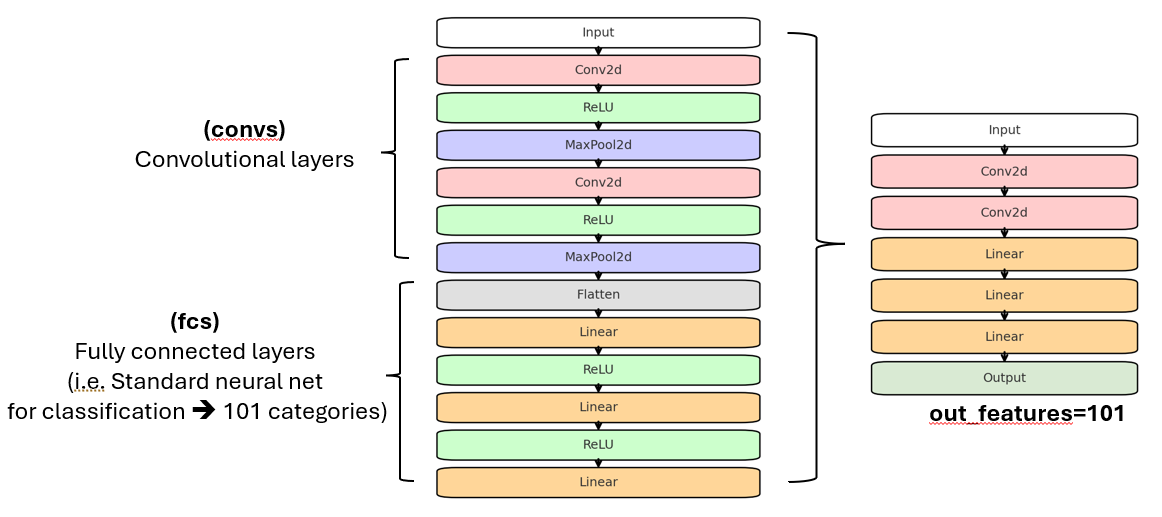

Comme on peut le voir, le réseau est composé de 2 couches de convolution (**Conv2d**) suivi de 3 couches de réseaux de neurones linéaires (**Linear**).

- Les couches **Conv2d** transforment nos images (sous forme de tenseurs) en représentations plus **concentrées en information**.  
- Les couches **Linear**, ensuite, utilisent ces informations **concentrées** pour déterminer à laquelle des **101 catégories** l’image appartient.  

Chaque couche correspond à une opération mathématique, et l’ensemble du réseau peut être vu comme un **mille-feuille d’opérations non linéaires**.  


**!! Attention,** nous venons de créer un réseau de neurons avec 101 sorties à la dernière couche (pour les 101 classes de notre jeu de données initial), mais nous venons tout juste de sous-échantillonés notre dataset pour qu'il contienne seulement 10 classes.

**Question :** Initialisez le modèle dans la variable `model` mais pour qu'il fonctionne sur notre sous-échantillons de n_classes = 10


In [ ]:
# Écrivez votre code ici:



In [ ]:
#@title Réponse :
n_classes = 10

model = Network1(n_classes=n_classes, img_size=img_size)
print(model)

### ⚡ Comment entraîne-t-on un réseau de neurones ?

1. **On lui donne des exemples** :  
   - Des **données d’entrée** (ex. images de gaufres et de pizzas)  
   - Et leurs **réponses attendues** (gaufres ou pizzas).  

2. **Le réseau fait une prédiction**  

3. **On mesure l’erreur** avec une **fonction de perte** (*loss*) qui compare la prédiction à la bonne réponse.  

4. **On ajuste les paramètres** du réseaux de neurones grâce à un **algorithme d’optimisation** (comme *SGD* ou *Adam*).
   - Plus la prédiction est éloignée de la bonne réponse (*large loss*), plus les paramètres sont ajustés.
   - À l’inverse, plus la prédiction est correcte (*small loss*), moins les paramètres sont modifiés.

5. **On répète le processus** des milliers de fois sur beaucoup d’exemples, jusqu’à ce que le réseau apprenne à faire de bonnes prédictions.  

---


### Définition de la fonction de perte (objectif de l'entraînement)

Puisque notre objectif est de **prédire la classe** à laquelle chaque image appartient,  
nous allons utiliser la **Cross-Entropy Loss** (*fonction d’entropie croisée*).  
Celle-ci mesure l’écart entre :  
- la **distribution prédite** par le modèle,  
- et la **distribution réelle** (celle des étiquettes).  

En théorie, plus cette valeur est **faible**, plus le modèle est performant.  
Nous la calculons à la fin de chaque itération d’entraînement pour savoir si le modèle progresse vers l’objectif.  

On peut voir cela de la façon suivante :  
- nous cherchons les **meilleurs paramètres possibles** pour obtenir le réseau qui produit les **meilleures prédictions** ;  
- si toutes les combinaisons possibles de paramètres étaient représentées dans un **espace 2D**,  
- la fonction de perte correspondrait à une **surface**,  
- et l’entraînement consisterait à trouver le **point le plus bas** de cette surface.  

En réalité l'espace des solutions a beaucoup plus de dimensions que simplement 2 dans le cas précédent. Néanmoins, pour se donner une idée, on pourrait le représenter ainsi :

![Alt Text](https://egallic.fr/Enseignement/ML/ECB/book/figs/example_two_dim/descent_2D_sphere.gif)

(image de https://egallic.fr)

In [ ]:
criterion = nn.CrossEntropyLoss()

## Fonction d'optimization des paramètres

L’optimiseur est l’outil qui détermine **comment le modèle se déplace vers le minimum** de la fonction de perte.  
En réalité, nous ne savons pas où se trouve ce minimum, et nous ne voulons pas avancer **au hasard** dans l’espace des solutions possibles.  

Si l’espace « descend », il est probable qu’un minimum se trouve dans cette direction.  
C’est ici que la **`learning_rate`** entre en jeu :  
- une valeur **trop élevée** risque de nous faire dépasser le minimum,  
- une valeur **trop faible** ralentira énormément l’entraînement.  

Il existe plusieurs types d’optimiseurs, chacun avec ses propriétés.  
Dans notre cas, nous allons simplement utiliser **SGD** (*Stochastic Gradient Descent*), l’un des plus couramment employés.  

In [ ]:
learning_rate = 0.001   # Taux d'apprentissage : contrôle la vitesse à laquelle les poids du modèle sont ajustés
momentum = 0.9          # Momentum : aide à accélérer l'entraînement
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # Définir notre fonction d'optimisation

## Boucle d'entraînement

Nous pouvons maintenant mettre en place la **boucle d’entraînement** de notre modèle.  

Dans cet exemple, nous choisissons de l’entraîner pendant **100 époques** (c’est-à-dire 100 passes complètes sur le jeu de données).  

À la fin de chaque époque, nous calculerons :  
- la **fonction de perte** (*loss*) afin de savoir si le modèle progresse dans la bonne direction,  
- l’**exactitude** (*accuracy*), une métrique plus intuitive pour un humain.  

Ces deux mesures seront également évaluées sur le **jeu de validation** à chaque époque.  
Elles nous permettront de déterminer si le modèle s’améliore vraiment et, en fin de compte, de choisir la version la plus adaptée à notre tâche.  


In [ ]:
n_epoch = 100

model.to(device)

train_and_validate(
    model=model,               # The neural network we want to train
    trainloader=trainloader,   # DataLoader providing the training dataset (batches of inputs + labels)
    validloader=validloader,   # DataLoader providing the validation dataset for performance checks
    criterion=criterion,       # Loss function used to measure prediction error
    optimizer=optimizer,       # Optimization algorithm (SGD) to update model parameters
    n_epoch=n_epoch,           # Number of times the model will iterate over the full training dataset
    device=device,             # Hardware to run on (CPU or GPU)
    n_classes=n_classes        # Number of output categories/classes for classification
)


In [ ]:
# Let's have a look at the predictions
from utils.utils import imshow, visualize_predictions

visualize_predictions(model, testloader, classes  , device)

## Veuillez vous arrêter ici afin d'attendre le reste du groupe
![Alt Text](https://media.tenor.com/WeazEANUhvMAAAAM/stop-funny-animal.gif)

**Question :**

Réfléchissez aux courbes que vous observez :  

- Pourquoi l’**exactitude en entraînement** atteint-elle **100 %**, alors que celle en **validation** reste bien plus basse ?  
- Le réseau s’est-il réellement **entraîné correctement** dans ce cas ?  


Ne descendez pas en dessous de l'image suivante pour ne pas voir les solutions ;)
![Alt Text](https://i.ibb.co/y44Wk1w/DSCF8918.jpg)
(jaseur d'Amérique mangeant une baie d'amélanchier, parc du Bic, Québec, 2023)


### Solutions pour surmonter le surapprentissage

Pour limiter les problèmes liés au **sur-apprentissage** (*overfitting*), plusieurs techniques peuvent être mises en œuvre :  

- **Réduire la complexité du modèle**  
  → en utilisant un modèle plus simple (dualité biais-variance),  
  ou en ajoutant des termes de **régularisation** dans la fonction de perte,  
  afin de limiter le nombre de paramètres utilisés.  

- **Augmenter la quantité de données d’entraînement**  
  → pour mieux capturer les caractéristiques réelles des données et réduire l’influence du bruit.  

- **Améliorer la qualité des données**  
  → en réduisant le bruit, en supprimant les données aberrantes ou mal annotées  
  qui ne reflètent pas la tendance générale.  

- **Utiliser la validation croisée**  
  → pour évaluer les performances du modèle sur plusieurs sous-ensembles de données  
  et mieux estimer sa capacité de généralisation.  

- **Appliquer des techniques d’augmentation de données** (*data augmentation*)  
  → afin d’accroître artificiellement la diversité des données d’entraînement.  


# Entraînement d’un second réseau de neurones

Que pouvons-nous faire pour **améliorer notre score sur le jeu de validation** tout en **réduisant le risque de surapprentissage** ?  

- ✅ **Réduire la complexité du modèle** : c’est une solution simple et efficace.  
- ⏳ **Augmenter la quantité de données** : possible, mais un trop grand volume rendrait l’entraînement beaucoup plus lent.  
- 📏 **Améliorer la qualité des images** : nous préférons conserver une résolution de **64 px** pour des raisons de rapidité.  
- 🔄 **Validation croisée** : une technique intéressante, mais trop longue à détailler dans le cadre de cet atelier.  
- 🎨 **Augmentation de données (Data Augmentation)** : un excellent moyen d’accroître artificiellement la diversité du jeu de données, afin d’éviter que le réseau n’apprenne les images « par cœur ».  



## Augmentation de la donnée, qu'est-ce que ça veut dire ?

Si un modèle **surapprend**, c’est qu’il est *trop performant* sur ses données d’entraînement.  
Or, obtenir davantage de données pour éviter qu’il n’apprenne « par cœur » peut vite devenir complexe…  
C’est particulièrement vrai dans le domaine de la **santé**, où les données sont souvent coûteuses et difficiles à collecter.  

Heureusement, il existe une solution simple pour **augmenter artificiellement** notre jeu de données : la **data augmentation**.  
Le principe est d’appliquer différentes **transformations** (plus ou moins agressives) sur les données existantes,  
de manière à donner l’impression au réseau qu’il dispose de **nouvelles images**.  


![Alt Text](https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/ea/ee/data-augmentation-image-augment.png)

(image de https://www.ibm.com/think/topics/data-augmentation)

Commençons donc par créer des transformations en conséquence !

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size), # Resize so the smaller edge of the image will be matched to this number.
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip the image horizontally with a probability of 0.5.
    transforms.RandomRotation(degrees=10), # Randomly rotate the image by a maximum of 10 degrees.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly change brightness, contrast, saturation, and hue.
    transforms.RandomCrop(img_size), # Make sure the image is squared N x N so crop a img_size square.
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Random translation by 10% of the image size.
    transforms.ToTensor(), # Convert to PyTorch tensor.
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize.
])


**Question:** Créez un `train_ds`et `valid_ds`de la même manière qu'avant, en choisissant les bonnes transformations, pas besoin de créer de nouvelles transformations pour le jeu de validation.

In [ ]:
# Écrivez votre code ici:







In [ ]:
#@title Réponse
train_ds = Food101Dataset(json_path='./data/food-101/meta2/train.json', root_dir='./data/food-101/images', transform=train_transforms)
valid_ds = Food101Dataset(json_path='./data/food-101/meta2/validation.json', root_dir='./data/food-101/images', transform=valid_transforms)


### Sous-échantillons du jeu de données

De la même manière, nous allons créer `subset_train_ds`et `subset_valid_ds`qui sont en fait des sous échantillons de nos jeux de données créés avec 10 classes et cette sois-ci 50 images par classe.

In [ ]:
# Don't worry too much about the code bellow
n_classes = 10 # number of class to keep in subset
n_samples_per_class = 50 # Number of img to keep per class
labels = np.array(train_ds.labels)

subsets_per_class = []
for class_idx in range(n_classes):
    class_indices = np.where(labels==class_idx)[0][:n_samples_per_class]
    subsets_per_class.extend(class_indices)

labels_valid = np.array(valid_ds.labels)

subsets_per_class_valid = []
for class_idx in range(n_classes):
    class_indices_valid = np.where(labels_valid==class_idx)[0][:n_samples_per_class]
    subsets_per_class_valid.extend(class_indices_valid)

# Create a Subset from the original dataset
subset_train_ds = Subset(train_ds, subsets_per_class)
subset_valid_ds = Subset(valid_ds, subsets_per_class_valid)

On peut alors créer comme précédemment nos dataloaders


In [ ]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(subset_train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(subset_test_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

**Question :** Veuillez remplir la cellule pour `validloader` en fonction de `trainloader` à partir de subset_valid_ds.

In [ ]:
# Écrivez votre code ici






In [ ]:
#@title Réponse
batch_size = 4
validloader = torch.utils.data.DataLoader(subset_valid_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

On va cette fois-ci chercher un réseau de neurones moins complexe qui a été créé pour cet atelier :

In [ ]:
from networks.networks import Network2

model = Network2(n_classes=n_classes, img_size=img_size)
print(model)

Nous allons garder la même fonction de perte et le même optimiseur :

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

Cette fois-ci, comme nous avons beaucoup plus d'images à cause de l'augmentation de données, l'entraînement va être nettement plus long. Nous allons donc faire seulement 30 époques.

In [ ]:
n_epoch = 30

model.to(device)

train_and_validate(
    model=model,
    trainloader=trainloader,
    validloader=validloader,
    criterion=criterion,
    optimizer=optimizer,
    n_epoch=n_epoch,
    device=device,
    n_classes=n_classes
)


In [ ]:
# Let's have a look at the predictions
visualize_predictions(model, testloader, classes  , device)

## Veuillez vous arrêter ici afin d'attendre le reste du groupe
![Alt Text](https://media.tenor.com/WeazEANUhvMAAAAM/stop-funny-animal.gif)

Vous pouvez réfléchir aux courbes que vous voyez
Pourquoi l'exactitude en entraînement ne monte pas à 100% ?
Le réseau s'est-il entraîné correctement ?

Ne descendez pas en dessous de l'image suivante dans le but de ne pas voir les solutions ;)
![Alt Text](https://i.ibb.co/bF7L6Ms/DSCF1170-2.jpg)
(Cerf de Virginie mangeant les fruits des rosiers sauvages, parc du Bic, Québec, 2022)

### Solutions pour surmonter le sous-apprentissage

Pour limiter les problèmes liés au **sous-apprentissage** (*underfitting*), plusieurs techniques peuvent être mises en œuvre :  

- **Augmenter la complexité du modèle**  
  → afin de lui donner davantage de capacité de représentation.  

- **Augmenter la quantité de données disponibles**  
  → pour améliorer la généralisation du modèle sur les concepts intrinsèques aux données.  

- **Prolonger la durée d’entraînement**  
  → en augmentant le nombre d’itérations ou d’époques, afin de permettre au modèle d’apprendre plus en profondeur.  


# L'apprentissage par transfert
Nous voici un peu coincés : nous ne voulons pas trop augmenter notre donnée, sinon l'apprentissage devient trop long.  
Mais si nous utilisons des modèles trop petits, nous **sous-apprenons**, et si nous en utilisons de trop grands, nous **surapprenons**.  

---

Il existe néanmoins une méthode très pratique qui s'appelle **l'apprentissage par transfert**.  
Celle-ci consiste à utiliser un **modèle préentraîné** sur une tâche (généralement avec un grand volume de données) comme point de départ,  
puis à l'adapter pour une tâche **connexe mais différente**, avec éventuellement moins de données disponibles.  

---

Pour le processus de **raffinement des poids** (*fine-tuning*) sur une nouvelle tâche (celle que nous désirons réaliser) :  
- le modèle avec ses poids préentraînés est utilisé comme point de départ pour commencer un nouvel apprentissage (sur un nouveau jeu de données avec une nouvelle cible à atteindre — *training loss*),  
- le nouvel entraînement est réalisé généralement avec un **taux d'apprentissage très faible** (*learning rate*),  
- afin de ne pas perturber les paramètres initiaux du modèle et d’éviter de « perdre » les représentations déjà apprises (*oubli catastrophique*).  

---

Ainsi, l'idée principale est de permettre au modèle **d'adapter ses représentations apprises** aux spécificités de la nouvelle tâche,  
tout en se basant sur les représentations du modèle original (préentraîné).  

---

L'ensemble du processus de transfert de connaissances et de raffinement du modèle peut être résumé ainsi :  
- **Préentraînement** d'un modèle sur une tâche générale (par ex. classification d’images sur le jeu de données *ImageNet*).  
- **Utilisation** du modèle et de ses poids préentraînés comme nouveau point de départ.  
- **Ajustement des poids** (*fine-tuning*) sur la nouvelle tâche (avec un jeu de données généralement plus petit que celui utilisé pour le préentraînement).  


### Préentraînement (Transfert-learning)
Considérant que le transfert learning est une pratique courante, il existe une multitude de bibliothèques en ligne qui rendent accessibles les poids préentraînées sur différentes tâches pour toutes les architectures des modèles populaires (voir par example [PyTorch](https://docs.pytorch.org/vision/main/models.html) et [HuggingFace](https://huggingface.co/) )

**Nous n'avons donc pas à faire le préentraînement ce qui est l'élément clé du transfert learning (nous sauvons beaucoup de temps et de ressources).**

**Architecture :**

Prenons le réseau [EfficientNet_V2_S](https://arxiv.org/abs/2104.00298) qui est un réseau de neurones convolutioneldont l'architecture a été spécialement déveloper pour l'analyse d'images.

**Poids des connections :**

De plus, au lieu de prendre un réseau dont le poid initial des connections est initialisé alléatoirement, nous pouvons importer un réseau EfficientNet préentraîné sur le jeu de données [ImageNet1K](https://huggingface.co/datasets/mlx-vision/imagenet-1k), qui contient environ 1,4 million d’images d’objets réparties en 1 000 classes (pas juste des catégories de plats).

Ainsi, les poids utilisés ne sont donc pas initialisés aléatoirement, mais plutôt issus de l'entrainement sur une base déjà existante qui renferme plusieurs concepts permettant de représenter le contenu d'une image.

Le tout est disponible dans le [model hub Pytorch](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html).



In [ ]:
from torchvision.models import efficientnet_v2_s # Importing model architecture
from torchvision.models import EfficientNet_V2_S_Weights # Importing model weights

efficient_net_B0  = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

On peut voir que c'est un nettement plus gros réseau de neurones ! De plus, il est écrit de manière à prendre des images de 224 x 224px en entrée. On pourrait se dire que ça va être beaucoup trop long à entraîner, néanmoins, il y a une petite astuce.

### Raffinement d'un modèle (Finetuning)
L’objectif est maintenant de **reconnaître des images regroupées dans 101 classes de plats**,  
plutôt que dans les **1000 classes d’ImageNet-1K**.  

Créons nos transformations : nous allons rester simples cette fois-ci,  
car les images sont déjà grandes et difficiles à apprendre.

In [ ]:
img_size = 224
train_transforms = transforms.Compose([transforms.Resize(img_size), # Resize so the smaller edge of the image will be matched to this number.
                                       transforms.RandomCrop(img_size), # Make sur the image is squared N x N so crop a img_size square
                                       transforms.ToTensor(), # To pytorch tensor
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # normalize (x-mean)/std

valid_transforms = transforms.Compose([transforms.Resize(img_size),
                                       transforms.CenterCrop(img_size), # Center crop as we do not want randomness in test
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

On en profite pour refaire les datasets (dont le test que nous utiliserons tout à la fin)

In [ ]:
train_ds = Food101Dataset(json_path='./data/food-101/meta2/train.json', root_dir='./data/food-101/images', transform=train_transforms)
valid_ds = Food101Dataset(json_path='./data/food-101/meta2/validation.json', root_dir='./data/food-101/images', transform=valid_transforms)
test_ds = Food101Dataset(json_path='./data/food-101/meta2/test.json', root_dir='./data/food-101/images', transform=valid_transforms)

Et nos dataloaders :

(l'avertissement(warning) est normal)

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

### Modification de la couche de sortie
Dans le but d'accélérer le processus et à des fins de démonstrations, nous allons entraîner seulement la couche de sortie du réseau. Les autres paramètres resteront fixés et donc la dernière couche devra s'adapter aux concepts appris lors du préentraînement.

Nous allons donc modifier la dernière couche de sorte qu'elle exprime 101 sorties plutôt que les 1000 classes d'ImageNet.

In [ ]:
print(f"Number of parameters before modifying last layer : {sum(p.numel() for p in efficient_net_B0.classifier[-1].parameters())}")
efficient_net_B0.classifier[-1] = nn.Linear(1280, 101)
print(f"New number of parameters used in the last layer : {sum(p.numel() for p in efficient_net_B0.classifier[-1].parameters())}")

Il est maintenant possible de constater que la dernière couche contient maintenant 101 sorties et donc $1280*101 + 101 = 129 381$ paramètres.

1280 sorties de la couche cachée vers 101 sorties de la couche de prédiction pleinement connectées (+101 poids de biais).

Ces paramètres nouvellement initialisés aléatoirement doivent à présent être entraînés afin de réaliser la nouvelle tâche de classement.

### Gel des couches du réseau (excepté la couche de sortie)

In [ ]:
from torch.nn.modules.batchnorm import _BatchNorm

# First, freeze everything
for param in efficient_net_B0.parameters():
    param.requires_grad = False

# Unfreeze the final classifier layer
for param in efficient_net_B0.classifier[-1].parameters():
    param.requires_grad = True

# Ensure BatchNorm layers are in training mode
for layer in efficient_net_B0.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.train(True)

for name, layer in {n: l for n, l in efficient_net_B0.named_modules() if not list(l.children())}.items():
    grad_needed = [p.requires_grad for p in layer.parameters(recurse=False)]
    # print(f"`{name}` gradient needed: {bool(grad_needed) and all(grad_needed)}")

Il est possible de constater que la couche de sortie sera la seule entraînée et donc le graph de calcul du gradient ne contiendra que le gradient des poids de la couche de sortie. Cela va grandement accélérer le processus d'entraînement en réduisant le coût des calculs y étant relié.

Nous allons ici utiliser un autre optimiseur courant "Adam", vous pouvez changer la learning rate (lr), de préférence, il vaut mieux choisir une valeur entre 0.01 et 0.0001

In [ ]:
lr = 0.001 # learning rate
optimizer = optim.Adam(filter(lambda p: p.requires_grad, efficient_net_B0.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss()

### Boucle d'entraînement

Cet entraînement va prendre beaucoup plus de temps, mais va aussi arriver à de bons résultats en moins d'époques. Une époque peut prendre une dizaine de minutes, dans les fins de cet atelier, nous allons donc nous en tenir à un nombre assez bas, néanmoins n'hésitez pas à le relancer plus longtemps par vous-même.

In [ ]:
n_epoch = 2
n_classes = 101

model=efficient_net_B0
model.to(device)

train_and_validate(
    model=model,
    trainloader=train_loader,
    validloader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epoch=n_epoch,
    device=device,
    n_classes=n_classes
)


Comme au début de l'atelier, nous allons vouloir voir l'exactitude sur le jeu de test, on remet donc notre réseau en mode "évaluation".

In [ ]:
model.eval()
model.to(device)

accuracy = compute_accuracy(model, test_loader, device)
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

De la même manière, affichons quelques images avec la vraie valeur et la prédiction de notre réseau :

In [ ]:
from utils.utils import imshow, visualize_predictions

visualize_predictions(model, test_loader, classes, device)

Enfin, nous allons afficher une matrice de confusion avec les 20 éléments les plus déroutants pour notre réseau (afficher les 101 classes serait assez illisible)

In [ ]:
from sklearn.metrics import confusion_matrix
from utils.utils import get_all_preds_and_targets, plot_most_confused

# Get predictions and actual targets
all_preds, all_targets = get_all_preds_and_targets(model, test_loader, device)

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds, labels=range(len(classes)))

# Plot the top 20 most confused pairs
plot_most_confused(conf_matrix, classes, num_pairs=20)
